# Load packages

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

import sympy
from sympy import *
from sympy import symbols, Eq, solve
from shapely.geometry import LineString


%matplotlib inline
plt.style.use('ggplot')
import warnings
from scipy.stats import pearsonr
from matplotlib.patches import Patch
# import matplotlib.patches as Patch
# from matplotlib import patches as Patch
from matplotlib.lines import Line2D

output = 'Output14'
Input = 'Input4'

# Catchment descriptors

In [2]:
#HAI
def HAI_calculate(temp, precipitation):

    temp_adjusted = np.zeros(12)
    
    for i in range(1,13):
        if temp[i] < 0:
            temp_adjusted[i-1] = 0
        elif temp[i] > 30:
            temp_adjusted[i-1] = 30
        else:
            temp_adjusted[i-1] = temp[i]            
        
    T = np.sum(temp_adjusted)
    HAI = (58.93 * (T/12))/precipitation
    
    return HAI


#Function for the Seasonality Index
def Seasonality_index(Annual_mean, Monthly_mean):
    SI = (1/Annual_mean) * np.sum(np.abs(Monthly_mean - (Annual_mean/12)))
    
    return SI

#Function for Seasonality Timing Index
def ST_calc(dP,dT):
    days = 366
    ST = dP[0] * np.sign(dT[0]) * np.cos((np.pi * (dP[1] - dT[1]))/days)
    return ST

#Functions to compute Seasonal variability indexes
def T_daily(dT):
    t = np.linspace(1,366,366)
    days = 366
    T = T_mean + dT[0] * np.sin((2*np.pi * (t-dT[1]))/days)
    return T

def Cal_T_daily(dT):
    days = 366
    T_calc = T_daily(dT)
    
    return (np.sum(np.abs(T_calc - T_obs)))/days

def P_daily(dP):
    t = np.linspace(1,366,366)
    days = 366
    P = P_mean * (1 + dP[0] * np.sin((2*np.pi * (t-dP[1]))/days))
    return P

def Cal_P_daily(dP):
    days = 366
    P_calc = P_daily(dP)
    
    return (np.sum(np.abs(P_calc - P_obs)))/days

def E_daily(dE):
#    t = np.linspace(1,366,366)
    t = np.linspace(1,366,366)

    days = 366
    E = E_mean * (1 + dE[0] * np.sin((2*np.pi * (t-dE[1]))/days))
    return E

def Cal_E_daily(dE):
    days = 366
    E_calc = E_daily(dE)
    
    return (np.sum(np.abs(E_calc - E_obs)))/days


#Function for the interstorm duration or low_prec_freq
def Interstorm_duration(P):
    interstorm = []
    count = 0

    for j in range(len(P)):
        if P[j] < 1:
            count += 1
        elif P[j] >= 1 and count > 0:
            interstorm.append(count)
            count = 0 
    interstorm_duration = np.mean(interstorm)
    return interstorm_duration

#Function to compute the root-zone storage capacity
def rootzone(df_out, RP):
    firstyear = df_out['hydroyear'].iloc[0]
    lastyear = df_out['hydroyear'].iloc[-1]
    df_out = df_out.drop(df_out[df_out['hydroyear']==firstyear].index)
    df_out = df_out.drop(df_out[df_out['hydroyear']==lastyear].index)
    years = df_out.groupby(['hydroyear'])
    SD = years['SD_sum'].max() - years['SD_sum'].min()
    var = gumbel_r.fit(SD)
    p = 1-1/RP
    Sr = gumbel_r.ppf(p, var[0],var[1])
    return(Sr, df_out)

#Function to compute the potential evaporation for CAMELS-USA
def calc_Makkink_knmi_USA(Temp, Rs, rho_w = 1000):
    """
    Rs in J/m2/day
    temp in degree C
    Eref in m/d
	zoals in Hiemstra en Sluiter 2011 (KNMI rapport)
    """
    Eref = np.zeros(len(Temp))
    for i in range(len(Temp)):
        gamma=0.0646+0.00006*Temp[i]                    #psychrometer constante (kPa/C)
        labda=1000*(2501-2.38*Temp[i])                  #verdampingswarmte water (J/kg)
        es=0.6107*10**((7.5*Temp[i])/(237.3+Temp[i]));              #verzadigde dampingspanning tov water (C)
        Slope=((7.5*237.3)/((237.3+Temp[i])**2))*np.log(10)*es;  #verzadigde dampspanningsgradient tov water (kPa/C)
        Eref[i]=0.65*(Slope/(Slope+gamma))*(Rs[i]/(rho_w*labda));   #Referentie gewasverdamping (mm/etmaal)
    return Eref

def w_function(AI, w):
    EI = 1 + AI - (1 + (AI**w))**(1/w)
    return EI

# Catchment Selection 

In [3]:
"""
CAMELS-USA: Catchment selection
Adding the latitude and longitude to the file that contains the frac_snow.
Then based on the frac_snow, the lon and lat the data is cut. 
This information is then transferred to a file

"""

frac_snow = pd.read_csv("1_Data/CamelsUSA3/camels_clim.txt", delimiter=';', parse_dates=[0], skipinitialspace=True)
topo      = pd.read_csv("1_Data/CamelsUSA3/camels_topo.txt", delimiter=';', parse_dates=[0], skipinitialspace=True)

frac_snow['gauge_lat'] = topo['gauge_lat']
frac_snow['gauge_lon'] = topo['gauge_lon']

max_lon, min_lon, max_lat, min_lat = [-60, -100, 70, 32]

selected = frac_snow.loc[(frac_snow['frac_snow'] <= 0.1)     & 
                         (frac_snow['gauge_lon'] >  min_lon) & 
                         (frac_snow['gauge_lon'] <  max_lon) & 
                         (frac_snow['gauge_lat'] >  min_lat) & 
                         (frac_snow['gauge_lat'] <  max_lat)]

#Save and import the selected catchments
selected.to_csv("3_Selected/Selectedcatchments2.csv")
df  = pd.read_csv("3_Selected/Selectedcatchments2.csv", delimiter=',', parse_dates=[0], skipinitialspace=True)


def Catch_name(num, length):
    """
    The function checks the length of the gauge_id
    adds a 0 before the number to match the length of the file names.    
    """
    if len(str(abs(num))) <= length-2:
        print('problem with function Catch_name, length to short')
        
    if len(str(abs(num))) == length-1:
        num_new = str('0')+str(num)
        
    if len(str(abs(num))) == length:
        num_new = num
        
    if len(str(abs(num))) > length:
        print('problem with function Catch_name, length to long')
        
    return num_new

#Adding the selected catchments to a list.
catchment_list_USA = []
catchment_2 = []
for i in range(len(df)):
    catchment_2.append(df['gauge_id'][i])
    catchment_list_USA.append(Catch_name(df['gauge_id'][i], 8))
    


# removing = ['02108000', '01586610', '01669520', '02096846', '02137727' , '02140991', '02193340', '02196000', '02198100', '02215100' , '02384540', '02415000', '02464146', '02464360', '03338780', '05592575','06906800', '06934000', '07359610', '07362587', '08050800', '07067000','07263295', '01466500', '02092500', '02381600', '02465493', '03280700', '03281100', '03450000', '03500000', '03500240', '06803510', '06803530','06876700', '06878000', '07060710', '07142300', '07145700','07148400']
removing = ['02108000', '01586610', '01669520', '02096846', '02137727' , '02140991', '02193340', '02196000', '02198100', '02215100' , '02384540', '02464000', '02415000', '02464146', '02464360', '03338780', '05592575','06906800', '06934000', '07359610', '07362587', '08050800', '07067000','07263295' , '01466500', '02092500', '02381600', '02465493', '03280700', '03281100', '03450000', '03500240', '03500000', '07060710'] #, '06803510', '06803530','06876700', '06878000', , '07142300', '07145700','07148400']

for i in range(len(removing)):
    # print(removing[i])
    catchment_list_USA.remove(removing[i])

# Load data

## Determine time slices

In [ ]:
yrcut = [1981, 1990, 2000 , 2010] # laatste jaar zit er niet in
colors = ['#9FB2FF', '#496AFF', '#0020AF', '#001678']
colors2 = ['#6CC24A','#FFB81C', '#A50034']
yrsl = []
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
print(yrsl)

## Loop through catchments

### Determine AI & ST total

In [9]:
catchment_list = catchment_list_USA
AI_total = []
ST_total = []

for i in range(len(catchment_list)): 
    # print(catchment_list[i])
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
        
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0
        
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['TAIR'][k])+1):
            T1[count] = daily_sliced_mean['TAIR'][k,m]
            P1[count] = daily_sliced_mean['PRCP'][k,m]
            E1[count] = daily_sliced_mean['Ep_Mak_knmi'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)
            
    de = res_E.x[0]
    se = res_E.x[1] / 366
            
    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    
    AI_total.append(AI)
    ST_total.append(ST)


### Calculate AI & ST cuts

In [10]:
ngroup_AI = round(len(AI_total)/3)
AI_total.sort()
cut1_AI = AI_total[ngroup_AI-1]
cut2_AI = AI_total[2*ngroup_AI-1]

ngroup_ST = round(len(ST_total)/3)
ST_total.sort()
cut1_ST = ST_total[ngroup_ST-1]
cut2_ST = ST_total[2*ngroup_ST-1]
max_ST = max(ST_total)
min_ST = min(ST_total)

print(cut1_AI, cut2_AI)
print(cut1_ST, cut2_ST)
print(min(ST_total))
print(max(ST_total))

0.7792745505727925 0.8554919519917887
0.08362189386407964 0.1898975564691315
-0.09705697099376503
0.7358687474023953


### Loop 

Exclude catchment with ID (2) 03592718


AttributeError: 'LineString' object has no attribute 'x'

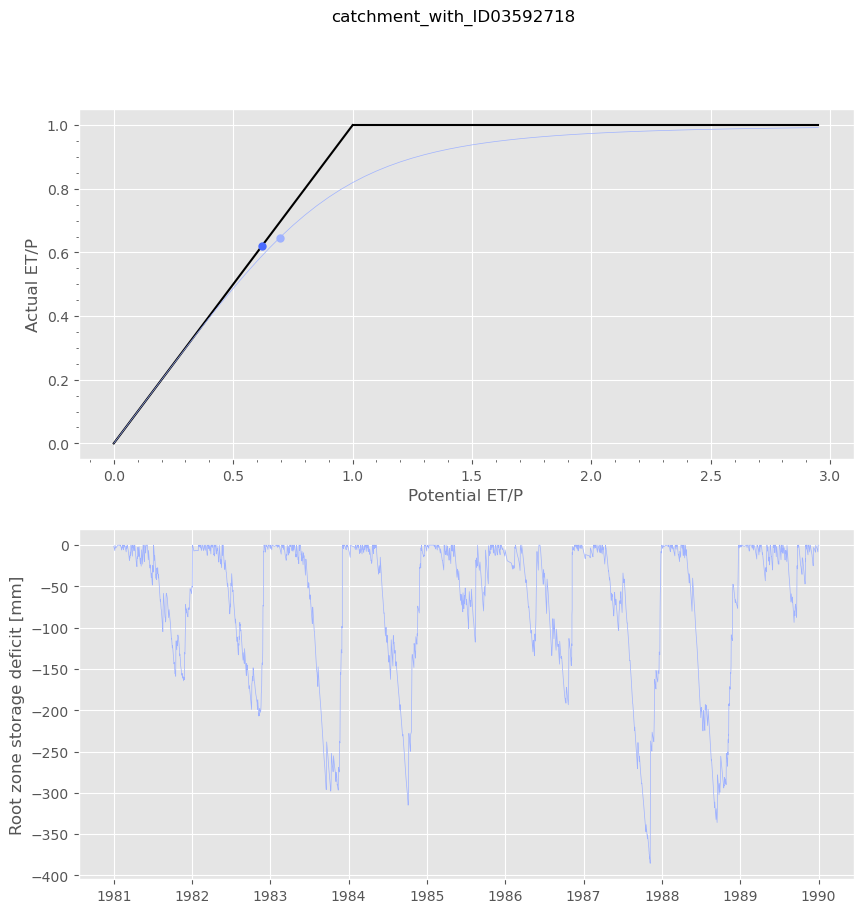

In [11]:
warnings.filterwarnings('ignore')
catchment_list = catchment_list_USA
df_output = pd.DataFrame(index=catchment_list)
catchment_list_arid = []
catchment_list_med = []
catchment_list_wet = []
catchment_list_STlow = []
catchment_list_STmed = []
catchment_list_SThigh = []

for i in range(len(catchment_list)): 
    # print(catchment_list[i])
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
    # Calculate root zone storage deficits
    RP    = 20 # Return-period of 20 years
    P_ts  = data['PRCP']
    EP_ts = data['Ep_Mak_knmi']

    Et = np.zeros(len(P_ts))
    SD = np.zeros(len(P_ts))

    for z in range(len(P_ts)):
        Et[z] = (EP_ts[z]/Ep) * Ea
        if z == 0:
            SD[z] = min(0, P_ts[z] - Et[z])
        else:
            SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
    data.loc[:,'SD'] = SD
            
    data['year'] = pd.DatetimeIndex(data['date']).year
    df_out = pd.DataFrame(index = data.index)
    df_out['hydroyear'] = data['year']
    df_out['SD_sum'] = data['SD']
    Sr = rootzone(df_out,RP)[0]    
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0
        
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['TAIR'][k])+1):
            T1[count] = daily_sliced_mean['TAIR'][k,m]
            P1[count] = daily_sliced_mean['PRCP'][k,m]
            E1[count] = daily_sliced_mean['Ep_Mak_knmi'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)
            
    de = res_E.x[0]
    se = res_E.x[1] / 366
            
    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    
   
    if AI <= cut1_AI:
        catchment_list_wet.append(catchment_list[i])
    elif cut1_AI <= AI <= cut2_AI:
        catchment_list_med.append(catchment_list[i])
    elif cut2_AI < AI:
        catchment_list_arid.append(catchment_list[i])
        
        
    if ST <= cut1_ST:
        catchment_list_STlow.append(catchment_list[i])
    elif cut1_ST <= ST <= cut2_ST:
        catchment_list_STmed.append(catchment_list[i])
    elif cut2_ST < ST:
        catchment_list_SThigh.append(catchment_list[i])
    
    # print(f'Catchment {catchment_list[i]} with AI {AI} and EI {EI} and Ea {Ea} and Ep {Ep}')

    if AI < EI or Ea < 0:
        print(f'Exclude catchment with ID {catchment_list[i]}')
        
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    df_output.loc[catchment_list[i],[f'AI']] = AI
    df_output.loc[catchment_list[i],[f'EI']] = EI
    df_output.loc[catchment_list[i],[f'Sr']] = Sr
    
    # Seperate data into slices
    # data['year'] = pd.DatetimeIndex(data['date']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['YR']) & (data['YR'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_Mak_knmi'].mean()    
        T = datanew['TAIR'].mean()
        P  = datanew['PRCP'].mean()
        Q  = datanew['OBS_RUN'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
        
        axs[0].plot(AI, EI, marker='o', color=c,markersize=5)
        
        # print(f'Year {yrsl[j]} Catchment {catchment_list[i]} with AI {AI} and EI {EI} and Ea {Ea} and Ep {Ep}')
            
        if AI < EI or Ea < 0 :
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                                
        EI_line = np.linspace(EI, EI, 100000)
        w_array = np.linspace(0, 15, 100000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c, linewidth = 0.5)
        
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['PRCP']
        EP_ts = datanew['Ep_Mak_knmi']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z] / Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['dt'], datanew['SD'], linewidth = 0.5, c=c)
        
        datanew['year'] = pd.DatetimeIndex(datanew['date']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        Sr = rootzone(df_out,RP)[0]
        
        #Annual precipitation values
        data_y = datanew.resample('A').sum()
        Pa = data_y['PRCP'].mean()
       
        #monthly_mean_values:
        data_m_sum = datanew.resample('M').sum()
        monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
        P_m_sum = np.zeros(12)
        P_m_sum = monthly_sliced_sum['PRCP']
        
        data_m_mean = datanew.resample('M').mean()
        monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
        T_m_mean = np.zeros(12)
        T_m_mean = monthly_sliced_mean['TAIR']
        
        
        #Compute the seasonality variability indexes
        data_d = datanew.resample('d').mean().bfill()
        daily_sliced_mean = datanew.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
        T1 = np.zeros((366))
        P1 = np.zeros((366))
        E1 = np.zeros((366))
        count = 0
        
        for k in range(1,13):
            for m in range(1,len(daily_sliced_mean['TAIR'][k])+1):
                T1[count] = daily_sliced_mean['TAIR'][k,m]
                P1[count] = daily_sliced_mean['PRCP'][k,m]
                E1[count] = daily_sliced_mean['Ep_Mak_knmi'][k,m]
                count += 1
        t = np.linspace(1,366,366)
    
        T_obs = T1
        P_obs = P1
        E_obs = E1

        T_mean = np.nanmean(T_obs)
        P_mean = np.nanmean(P_obs)
        E_mean = np.nanmean(E_obs)

        x0_T = [5, 110]
        x0_P = [0.3, 40]
        x0_E = [0.4, 40]
        lb = [0, np.inf]
        ub = [0, 366]
    
        res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
        res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
        res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

        dp = res_P.x[0]
        sp = res_P.x[1] / 366
        dt = res_T.x[0]
        st = res_T.x[1] / 366
        
        if abs(sp - st) <= 0.5:
            sd = sp - st

        elif (sp - st) > 0.5:
            sd = -1 + (sp - st)

        else:
            sd = 1 + (sp - st)
            
        de = res_E.x[0]
        se = res_E.x[1] / 366
            
        # Compute variables
        ST = ST_calc(res_P.x,res_T.x)
        HAI = HAI_calculate(T_m_mean, Pa)
        SI = Seasonality_index(Pa, P_m_sum)
        is_dur = Interstorm_duration(datanew['PRCP'])
            
        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w
        df_output.loc[catchment_list[i],[f'P {yrsl[j]}']] = P
        df_output.loc[catchment_list[i],[f'Ep {yrsl[j]}']] = Ep
        df_output.loc[catchment_list[i],[f'T {yrsl[j]}']] = T     
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'SI {yrsl[j]}']] = SI
        df_output.loc[catchment_list[i],[f'HAI {yrsl[j]}']] = HAI
        df_output.loc[catchment_list[i],[f'is_dur {yrsl[j]}']] = is_dur
        df_output.loc[catchment_list[i],[f'dp {yrsl[j]}']] = dp
        df_output.loc[catchment_list[i],[f'sp {yrsl[j]}']] = sp
        df_output.loc[catchment_list[i],[f'dt {yrsl[j]}']] = dt
        df_output.loc[catchment_list[i],[f'st {yrsl[j]}']] = st
        df_output.loc[catchment_list[i],[f'sd {yrsl[j]}']] = sd
        df_output.loc[catchment_list[i],[f'de {yrsl[j]}']] = de
        df_output.loc[catchment_list[i],[f'se {yrsl[j]}']] = se
        df_output.loc[catchment_list[i],[f'ST {yrsl[j]}']] = ST       
        df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']] = Sr            
            
            
    # axs[0].legend(loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments/Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)

# Calculate changes and output

## Calculate changes

In [12]:
descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Holdrigde Aridity Index', 'Interstorm duration', 'dp', 'sp', 'dt', 'st', 'sd', 'de', 'se', 'Seasonality Timing Index']
descriptors = ['P', 'Ep', 'T', 'AI', 'SI', 'HAI', 'is_dur', 'dp', 'sp', 'dt', 'st', 'sd', 'de', 'se', 'ST']

for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI_exp - EI
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            
display(df_output)

,AI,EI,Sr,AI 1981 - 1989,EI 1981 - 1989,omega 1981 - 1989,P 1981 - 1989,Ep 1981 - 1989,T 1981 - 1989,SI 1981 - 1989,...,HAI_change 2000 - 2009,is_dur_change 2000 - 2009,dp_change 2000 - 2009,sp_change 2000 - 2009,dt_change 2000 - 2009,st_change 2000 - 2009,sd_change 2000 - 2009,de_change 2000 - 2009,se_change 2000 - 2009,ST_change 2000 - 2009
01411300,0.794058,0.612706,233.865141,0.819113,0.580946,2.294597,3.001865,2.458868,12.397502,0.175957,...,0.008713,0.197318,0.030029,-0.822250,0.288644,0.002162,0.175588,-0.011581,-0.002579,0.088543
01484100,0.777149,0.665483,274.155304,0.835441,0.687383,3.222022,3.051034,2.548960,13.273277,0.161583,...,-0.023371,0.318066,0.017859,-0.834656,0.330227,0.001287,0.164057,-0.009750,-0.002684,0.091399
01485500,0.798881,0.655936,283.912955,0.815095,0.660971,3.012803,3.158071,2.574126,13.662346,0.195808,...,-0.012852,0.226516,0.118222,-0.565945,0.166485,0.000386,-0.566332,-0.005715,-0.002543,0.145937
01486000,0.818090,0.670349,290.117346,0.833438,0.704580,3.500393,3.157448,2.631537,13.903365,0.185682,...,-0.016332,0.189554,0.142455,-0.751147,0.156601,0.001286,0.247567,-0.012775,-0.005266,0.217929
01487000,0.777241,0.639556,250.916376,0.828433,0.674418,3.096708,3.059093,2.534255,13.367551,0.169073,...,-0.025581,0.293061,0.038512,-0.819530,0.297974,0.001522,0.178948,-0.014888,-0.002197,0.141002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07346045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07362100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08082700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08086212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate expected Sr

In [13]:
warnings.filterwarnings('ignore')
catchment_list = catchment_list_USA

for i in range(len(catchment_list)): 
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()
    
    # Seperate data into slices
    # data['year'] = pd.DatetimeIndex(data['date']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['YR']) & (data['YR'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]

            # Compute the Makkink potential evaporation
            Ep = datanew['Ep_Mak_knmi'].mean()    
            T = datanew['TAIR'].mean()
            P  = datanew['PRCP'].mean()
            Q  = datanew['OBS_RUN'].mean()

            # Compute actual evaporation and Evaporative Index and Aridity index
            AI = Ep / P   
            EI = Ea / P 

            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P

            # Calculate root zone storage deficits
            RP    = 20 # Return-period of 20 years
            P_ts  = datanew['PRCP']
            EP_ts = datanew['Ep_Mak_knmi']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z] / Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

            datanew['year'] = pd.DatetimeIndex(datanew['date']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
            
            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr
        
display(df_output)       

,AI,EI,Sr,AI 1981 - 1989,EI 1981 - 1989,omega 1981 - 1989,P 1981 - 1989,Ep 1981 - 1989,T 1981 - 1989,SI 1981 - 1989,...,dp_change 2000 - 2009,sp_change 2000 - 2009,dt_change 2000 - 2009,st_change 2000 - 2009,sd_change 2000 - 2009,de_change 2000 - 2009,se_change 2000 - 2009,ST_change 2000 - 2009,Sr expected 1990 - 1999,Sr expected 2000 - 2009
01411300,0.794058,0.612706,233.865141,0.819113,0.580946,2.294597,3.001865,2.458868,12.397502,0.175957,...,0.030029,-0.822250,0.288644,0.002162,0.175588,-0.011581,-0.002579,0.088543,185.402347,245.939897
01484100,0.777149,0.665483,274.155304,0.835441,0.687383,3.222022,3.051034,2.548960,13.273277,0.161583,...,0.017859,-0.834656,0.330227,0.001287,0.164057,-0.009750,-0.002684,0.091399,221.150228,284.033360
01485500,0.798881,0.655936,283.912955,0.815095,0.660971,3.012803,3.158071,2.574126,13.662346,0.195808,...,0.118222,-0.565945,0.166485,0.000386,-0.566332,-0.005715,-0.002543,0.145937,289.516852,301.719510
01486000,0.818090,0.670349,290.117346,0.833438,0.704580,3.500393,3.157448,2.631537,13.903365,0.185682,...,0.142455,-0.751147,0.156601,0.001286,0.247567,-0.012775,-0.005266,0.217929,328.118588,288.663833
01487000,0.777241,0.639556,250.916376,0.828433,0.674418,3.096708,3.059093,2.534255,13.367551,0.169073,...,0.038512,-0.819530,0.297974,0.001522,0.178948,-0.014888,-0.002197,0.141002,226.502626,271.994944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07346045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07362100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08082700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08086212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate Sr change

In [14]:
for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            
display(df_output)

,AI,EI,Sr,AI 1981 - 1989,EI 1981 - 1989,omega 1981 - 1989,P 1981 - 1989,Ep 1981 - 1989,T 1981 - 1989,SI 1981 - 1989,...,dt_change 2000 - 2009,st_change 2000 - 2009,sd_change 2000 - 2009,de_change 2000 - 2009,se_change 2000 - 2009,ST_change 2000 - 2009,Sr expected 1990 - 1999,Sr expected 2000 - 2009,Sr deviation 1990 - 1999,Sr deviation 2000 - 2009
01411300,0.794058,0.612706,233.865141,0.819113,0.580946,2.294597,3.001865,2.458868,12.397502,0.175957,...,0.288644,0.002162,0.175588,-0.011581,-0.002579,0.088543,185.402347,245.939897,19.756732,58.376275
01484100,0.777149,0.665483,274.155304,0.835441,0.687383,3.222022,3.051034,2.548960,13.273277,0.161583,...,0.330227,0.001287,0.164057,-0.009750,-0.002684,0.091399,221.150228,284.033360,-6.310131,37.923203
01485500,0.798881,0.655936,283.912955,0.815095,0.660971,3.012803,3.158071,2.574126,13.662346,0.195808,...,0.166485,0.000386,-0.566332,-0.005715,-0.002543,0.145937,289.516852,301.719510,-6.326578,24.467118
01486000,0.818090,0.670349,290.117346,0.833438,0.704580,3.500393,3.157448,2.631537,13.903365,0.185682,...,0.156601,0.001286,0.247567,-0.012775,-0.005266,0.217929,328.118588,288.663833,-48.745622,27.416478
01487000,0.777241,0.639556,250.916376,0.828433,0.674418,3.096708,3.059093,2.534255,13.367551,0.169073,...,0.297974,0.001522,0.178948,-0.014888,-0.002197,0.141002,226.502626,271.994944,-8.606587,-2.020002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07346045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07362100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08082700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08086212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Save output

In [15]:
df_output.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/USA.csv')

# Plot Results

## Histograms EI deviations

### Histogram EI deviations combined time periods (overlapping)

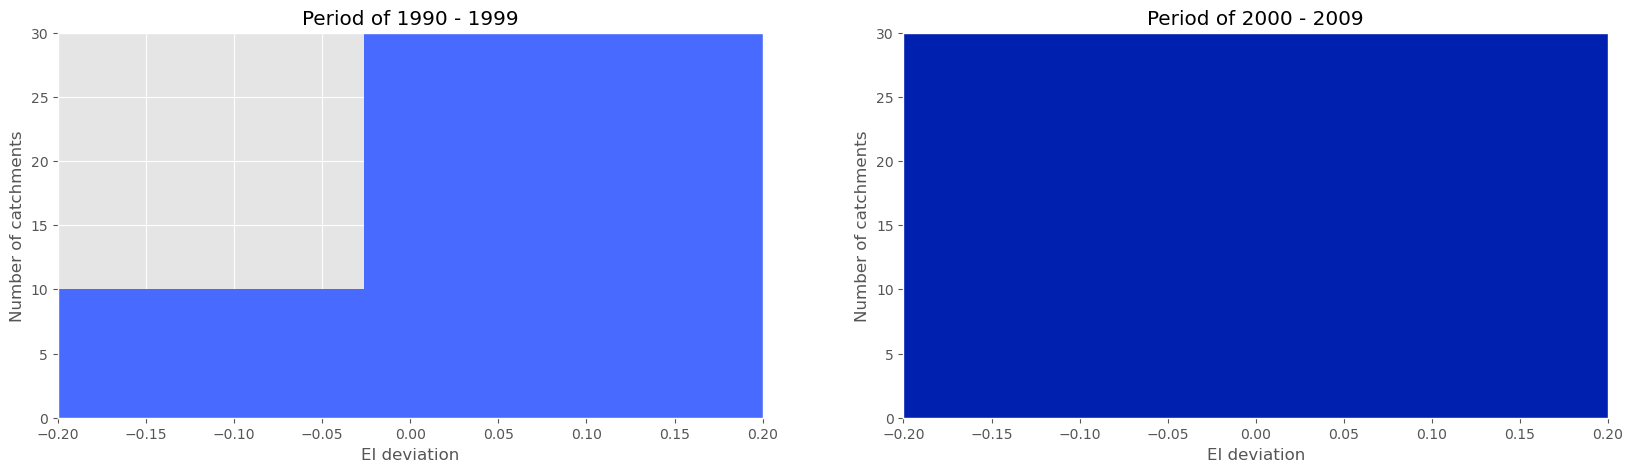

In [16]:
"Histogram EI deviations combined time periods (overlapping)"

n_tot = len(yrsl) - 1 
fig, axs = plt.subplots(1, n_tot)
fig.set_figheight(5)
fig.set_figwidth(20)

for j in range(len(yrsl)):
    if j > 0:
        yr = yrsl[j]
        c = colors[j]
        n = j - 1
        df_output.plot.hist(column=[f'EI deviation {yr}'], bins=1000,color=c, ax=axs[n], ylim=(0,30), xlim=(-0.2,0.2))
        axs[n].set_xlabel("EI deviation")
        axs[n].set_ylabel("Number of catchments")
        axs[n].set_title(f"Period of {yr}")
        axs[n].get_legend().remove()
    
plt.savefig(f'2_Output/{output}/Histograms/Histograms_EI.png')   
# plt.close(fig)

### Histogram EI deviations combined time periods (not overlapping)

[01411300   -0.027565
01484100    0.007443
01485500    0.008186
01486000    0.053054
01487000    0.010014
              ...   
07346045         NaN
07362100         NaN
08082700         NaN
08086212         NaN
08086290         NaN
Name: EI deviation 1990 - 1999, Length: 171, dtype: float64, 01411300   -0.071999
01484100   -0.044055
01485500   -0.026920
01486000   -0.029490
01487000    0.002293
              ...   
07346045         NaN
07362100         NaN
08082700         NaN
08086212         NaN
08086290         NaN
Name: EI deviation 2000 - 2009, Length: 171, dtype: float64]


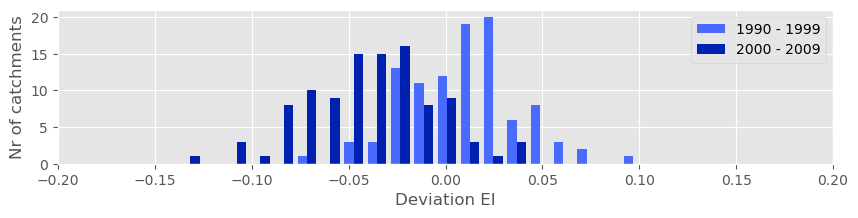

In [17]:
"Histogram EI deviations combined time periods (not overlapping)"
              
fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = ["", ""]


for j in range(len(yrsl)):  
    if j > 0:
        EI_dev = df_output[f'EI deviation {yrsl[j]}']
        EI_dev_grouped[j-1] = EI_dev
        
print(EI_dev_grouped)
        

plt.hist(EI_dev_grouped, bins=20, alpha = 1, color = colors[1:3], label=yrsl[1:3])        
plt.xlim(-0.2, 0.2)
plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')

# legend_el = [Patch(color=colors[0], label='Period 1'),
#              Patch(color=colors[1], label='Period 2'),
#              Patch(color=colors[2], label='Period 3')]

# plt.legend(handles=legend_el)

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_years_notoverlapping_v1.png')   

### Histogram EI deviations combined time periods

<Figure size 700x500 with 0 Axes>

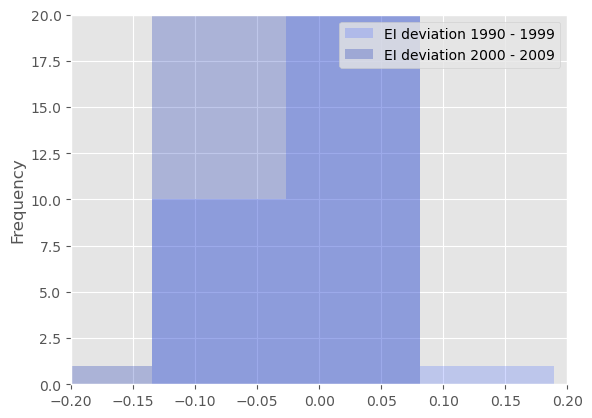

In [18]:
for j in range(len(yrsl)):
        if j > 0:
            yr = yrsl[j]
            c = colors[j]
            n = j - 1


fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(7)
              
df_output.plot.hist(column=[f'EI deviation {yrsl[1]}', f'EI deviation {yrsl[2]}'], bins=5000, color=[colors[1], colors[2]], alpha=0.25, ylim=(0,20), xlim=(-0.2,0.2))

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_5.png')   
# plt.close(fig)

### Histogram EI deviations grouped by aridity

0
1
2


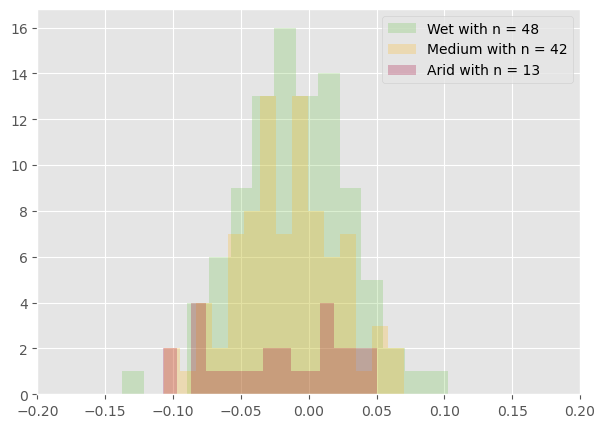

In [19]:
aridities = ["Wet", "Medium", "Arid"]

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(7)

for a in range(len(aridities)):
    print(a)
    EI_dev_total = []
    if a == 0:
        catchment_list = catchment_list_wet
    elif a == 1:
        catchment_list = catchment_list_med
    elif a == 2:
        catchment_list = catchment_list_arid
        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                # print(f'Catchment nr {catchment_list[i]} has an EI deviation of {EI_dev}')
                
    plt.hist(EI_dev_total, bins=15, alpha = 0.25, color = colors2[a], label=f'{aridities[a]} with n = {len(catchment_list)}')
    plt.xlim(-0.2, 0.2)


plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_5.png')   

### Histogram EI deviations grouped by aridity (not overlapping)

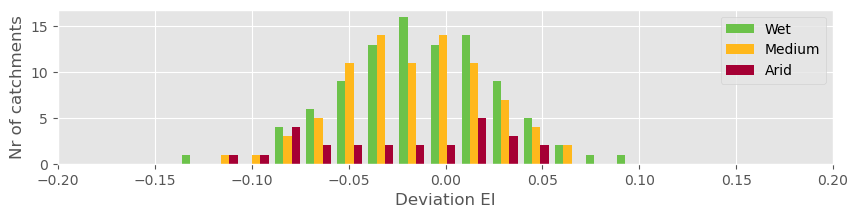

In [20]:
aridities = ["Wet", "Medium", "Arid"]
AI_names = [f"{min_AI:.2} < AI < {cut1_AI:.2}", f"{cut1_AI:.2} < AI < {cut2_AI:.2}", f"{cut2_AI:.2} < AI < {max_AI:.2}"]


fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = ["", "", ""]

for a in range(len(aridities)):
    EI_dev_total = []
    if a == 0:
        catchment_list = catchment_list_wet
    elif a == 1:
        catchment_list = catchment_list_med
    elif a == 2:
        catchment_list = catchment_list_arid
        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                # print(f'Catchment nr {catchment_list[i]} has an EI deviation of {EI_dev}')
                
                EI_dev_grouped[a] = EI_dev_total
                
plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = colors2, label=AI_names)
plt.xlim(-0.2, 0.2)

# legend_el = [Patch(color=colors2[0], label='Wet'),
#              Patch(color=colors2[1], label='Medium'),
#              Patch(color=colors2[2], label='Arid')]

# plt.legend(handles=legend_el)

plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histogram_time_combined_7.png')   

### Histogram EI deviations grouped by Seasonality Timin (not overlapping)

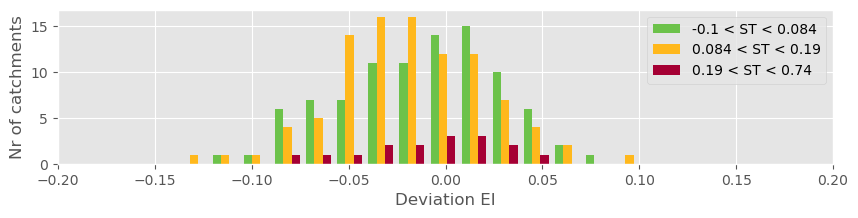

In [21]:
"Histogram EI deviations grouped by aridity (not overlapping)"

ST_names = [f"{min_ST:.1} < ST < {cut1_ST:.2}", f"{cut1_ST:.2} < ST < {cut2_ST:.2}", f"{cut2_ST:.2} < ST < {max_ST:.2}"]

fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(10)
EI_dev_grouped = ["", "", ""]

for a in range(len(ST_names)):
    EI_dev_total = []
    if a == 0:
        catchment_list = catchment_list_STlow
    elif a == 1:
        catchment_list = catchment_list_STmed
    elif a == 2:
        catchment_list = catchment_list_SThigh
        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                # print(f'Catchment nr {catchment_list[i]} has an EI deviation of {EI_dev}')
                
                EI_dev_grouped[a] = EI_dev_total
                
plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = colors2, label=ST_names)
plt.xlim(-0.2, 0.2)
plt.xlabel('Deviation EI')
plt.ylabel('Nr of catchments')

plt.legend(loc='upper right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_ST_notoverlapping_v1.png')   

## Plot correlations

In [22]:
for k in range(len(descriptors)):
    plt.suptitle('CAMELS GB')
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(5)
    fig.set_figwidth(7)
    
    EI_dev_total = []
    des_change_total = []
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                            
                plt.plot(df_output[f'{descriptors[k]}_change {yr}'], df_output[f'EI deviation {yrsl[j]}'], '.', c=colors[j])      

    x = des_change_total
    y = EI_dev_total
    
    pearson = pearsonr(x, y)
    m, b = np.polyfit(x, y, 1)
    pearsony = np.zeros(len(x))
    
    for q in range(len(EI_dev_total)):
        pearsony[q] = m * x[q] + b
    axs.plot(x, pearsony, 'k')
                
        
    axs.set_xlabel(f"Change in {descriptors_names[k]}")
    axs.set_ylabel(f"Devation Evaporative Index")
    axs.set_title(f"CAMELS USA {descriptors_names[k]}")
    
    
    legend = [Line2D([0], [0], marker='.', color='gainsboro', label=f'{yrsl[1]}',
                       markerfacecolor=f'{colors[1]}', markersize=15),
              Line2D([0], [0], marker='.', color='gainsboro', label=f'{yrsl[2]}',
                       markerfacecolor=f'{colors[2]}', markersize=15),
             Line2D([0], [0], color='k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" ,
                       markerfacecolor='k', markersize=10)]                    

    axs.legend(handles=legend,loc='lower right')
                
    plt.savefig(f'2_Output/{output}/Results/Change_total_time_{descriptors_names[k]}.png')   
    plt.close()

<Figure size 640x480 with 0 Axes>

### Plot correlations for seperate time periods

In [ ]:
for i in range(len(descriptors)):
    n_tot = len(yrsl) - 1 
    fig, axs = plt.subplots(1, n_tot)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    plt.suptitle('CAMELS GB')
    for j in range(len(yrsl)):
        if j > 0:
            yr = yrsl[j]
            c = colors[j]
            n = j - 1
            
            for c in range(len(df_output)):
                axs[n].plot(df_output[f'{descriptors[i]}_change {yr}'], df_output[f'EI deviation {yr}'], '.')      

            x = df_output[f'{descriptors[i]}_change {yr}']
            y = df_output[f'EI deviation {yr}']

                
            pearson = pearsonr(x, y)

            m, b = np.polyfit(x, y, 1)
            axs[n].plot(x, m*x + b, 'k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" )
            axs[n].legend(loc='lower right')
                
                
            axs[n].set_xlabel(f"Change in {descriptors_names[i]}")
            axs[n].set_ylabel(f"Devation Evaporation Index")
            axs[n].set_title(f"Change in {descriptors_names[i]} period of {yr}")
    plt.savefig(f'2_Output/{output}/Results/Change_{descriptors_names[i]}.png')   
    plt.close(fig)

## Plot EI expected

In [ ]:
catchment_list = catchment_list_USA

for i in range(len(catchment_list)): 
    # print(catchment_list[i])
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
        
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['date']).year  
    
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['YR']) & (data['YR'] < yrcut[j+1])]      
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_Mak_knmi'].mean()    
        T = datanew['TAIR'].mean()
        P  = datanew['PRCP'].mean()
        Q  = datanew['OBS_RUN'].mean()
        
        axs[0].plot(AI, EI, marker='o', color=c,markersize=5)
    
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)
        
        if j > 0:
            c_exp = colors[j-1]
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            axs[0].plot(AI, EI_exp, marker='d', color=c, markersize=5)
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['PRCP']
        EP_ts = datanew['Ep_Mak_knmi']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}'),
                Line2D([0], [0], color=colors[2], lw=1, label=f'{yrsl[2]}')]
                       

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)
    
    
print("end loop")

In [ ]:
catchment_list = catchment_list_USA

for i in range(len(catchment_list)): 
    # print(catchment_list[i])
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
        
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['date']).year  
    
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['YR']) & (data['YR'] < yrcut[j+1])]      
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_Mak_knmi'].mean()    
        T = datanew['TAIR'].mean()
        P  = datanew['PRCP'].mean()
        Q  = datanew['OBS_RUN'].mean()
        
        axs[0].plot(AI, EI, marker='o', color=c,markersize=5)
    
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)
        
        if j > 0:
            c_exp = colors[j-1]
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            axs[0].plot(AI, EI_exp, marker='d', color=c, markersize=5)
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['PRCP']
        EP_ts = datanew['Ep_Mak_knmi']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}'),
                Line2D([0], [0], color=colors[2], lw=1, label=f'{yrsl[2]}')]
                       

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)
    
    
print("end loop")

# Plot Budyko

In [ ]:
catchment_list = catchment_list_USA
plt.figure(figsize=(10,5)).suptitle("CAMELS USA (n=130)",fontsize=20)

for i in range(len(catchment_list)):     
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index       = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    data = data.loc["1981-01-01":"2008-12-31"]
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute Ea, AI, EI
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
    # Plot every catchment
    if Ea > 0 and AI > EI: 
        budyko_curve_x = np.arange(1, 3, 0.05)
        energy_limit_x = np.arange(0, 1.0001, 0.05)
        x = np.arange(0, 1.0001, 0.05)
        water_limit_y = 1 + budyko_curve_x*0
        energy_limit_y = energy_limit_x
        y = 1 + x*0
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.minorticks_on()
        plt.plot(energy_limit_x, energy_limit_y, c='k')
        plt.plot(budyko_curve_x, water_limit_y,c='k')
        
        plt.plot(AI, EI, marker='.', c = 'b')

        
plt.savefig(f'2_Output/{output}/Budyko.png')   
plt.close()